In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"  # change path if needed
df = pd.read_csv(DATA_PATH)
print("Loaded dataset with shape:", df.shape)
display(df.head())

Loaded dataset with shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print("\n--- Data Info ---")
display(df.info())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 

None

In [4]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
if df['TotalCharges'].dtype == object:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(" ", np.nan), errors='coerce')

print("\nAfter coercion, missing in TotalCharges:", df['TotalCharges'].isna().sum())



After coercion, missing in TotalCharges: 11


In [6]:
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])


In [7]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [8]:
if df['TotalCharges'].isna().sum() > 0:
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


In [9]:
print("\nChurn distribution:")
print(df['Churn'].value_counts())


Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


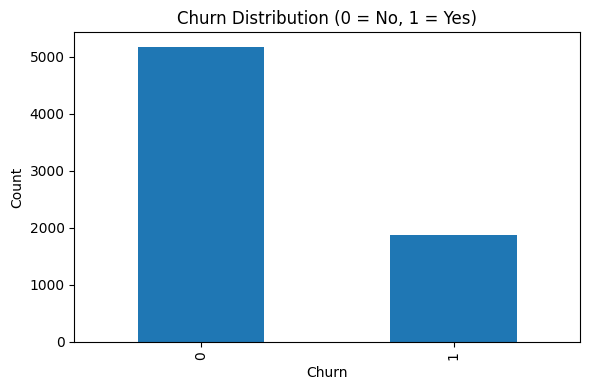

In [10]:
plt.figure(figsize=(6,4),)
df['Churn'].value_counts().plot(kind='bar')
plt.title("Churn Distribution (0 = No, 1 = Yes)")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

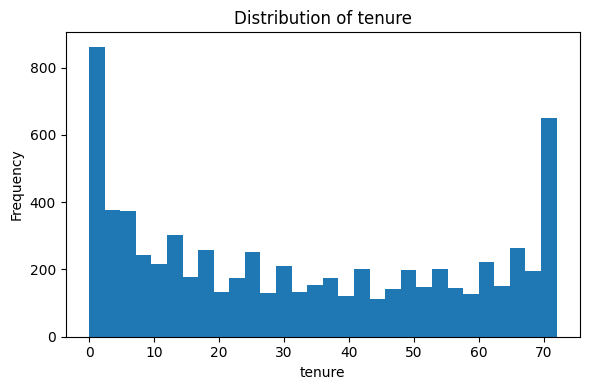

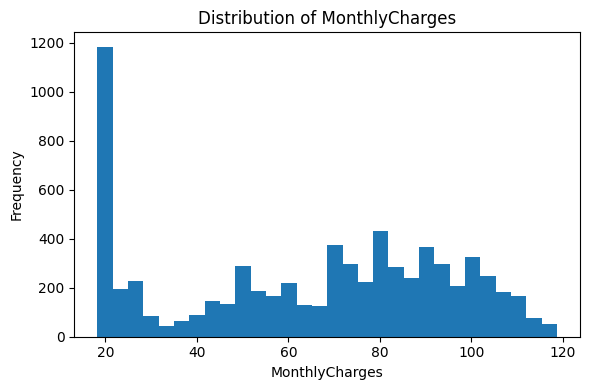

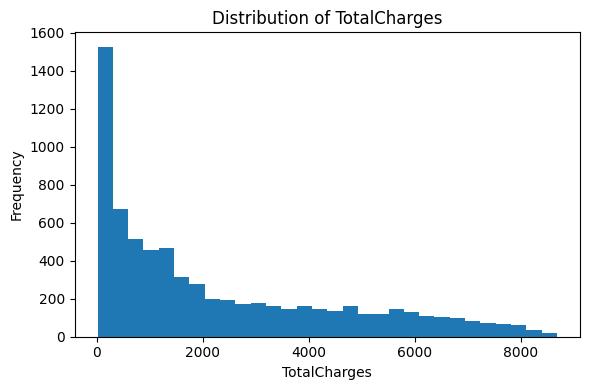

In [11]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


<Figure size 600x400 with 0 Axes>

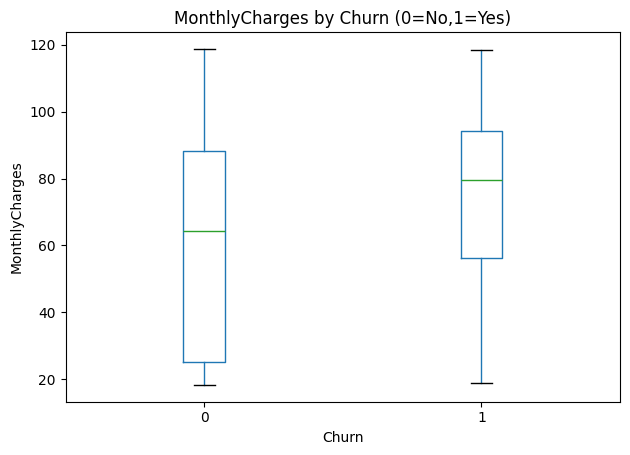

In [12]:
plt.figure(figsize=(6,4))
df.boxplot(column='MonthlyCharges', by='Churn', grid=False)
plt.suptitle('')
plt.title("MonthlyCharges by Churn (0=No,1=Yes)")
plt.xlabel("Churn")
plt.ylabel("MonthlyCharges")
plt.tight_layout()
plt.show()

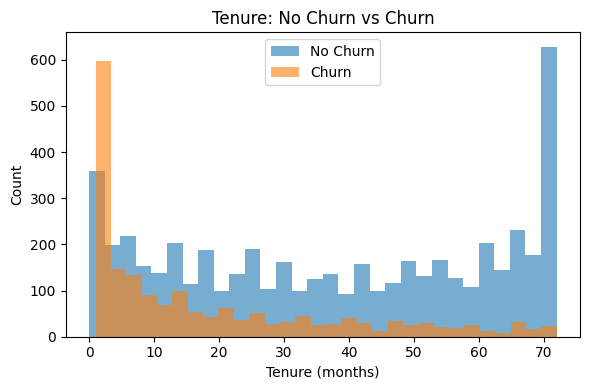

In [13]:
plt.figure(figsize=(6,4))
plt.hist(df[df['Churn']==0]['tenure'], bins=30, alpha=0.6, label='No Churn')
plt.hist(df[df['Churn']==1]['tenure'], bins=30, alpha=0.6, label='Churn')
plt.legend()
plt.title("Tenure: No Churn vs Churn")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


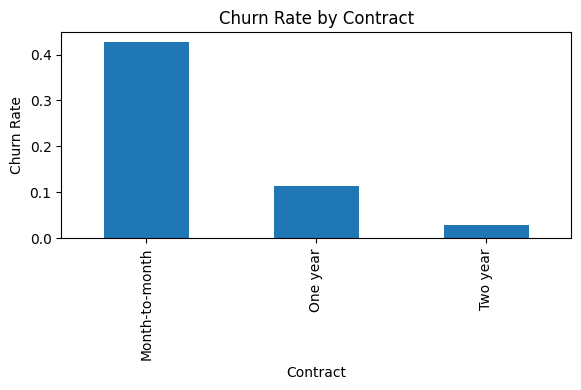


Churn rate by Contract:
 Contract
Month-to-month    0.427097
One year          0.112695
Two year          0.028319
Name: Churn, dtype: float64


In [14]:
contract_churn = df.groupby('Contract')['Churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
contract_churn.plot(kind='bar')
plt.title("Churn Rate by Contract")
plt.xlabel("Contract")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()
print("\nChurn rate by Contract:\n", contract_churn)


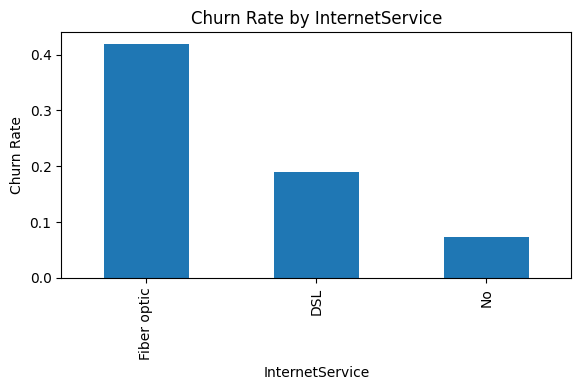


Churn rate by InternetService:
 InternetService
Fiber optic    0.418928
DSL            0.189591
No             0.074050
Name: Churn, dtype: float64


In [15]:
internet_churn = df.groupby('InternetService')['Churn'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
internet_churn.plot(kind='bar')
plt.title("Churn Rate by InternetService")
plt.xlabel("InternetService")
plt.ylabel("Churn Rate")
plt.tight_layout()
plt.show()
print("\nChurn rate by InternetService:\n", internet_churn)


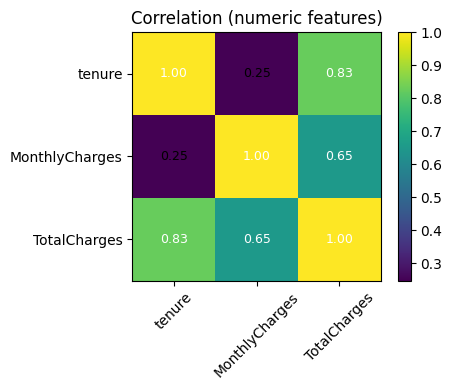

In [16]:
plt.figure(figsize=(5,4))
corr = df[num_cols].corr()
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
for (i, j), val in np.ndenumerate(corr.values):
    plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=9, color='white' if abs(val)>0.5 else 'black')
plt.title("Correlation (numeric features)")
plt.tight_layout()
plt.show()


In [21]:
categorical_features = [c for c in categorical_features if c not in binary_yes_no]
print("Categorical to OneHotEncode:", categorical_features)


Categorical to OneHotEncode: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [22]:
final_numerical = numerical_features + binary_yes_no
final_categorical = categorical_features


In [23]:
for c in final_numerical:
    if df[c].isna().sum() > 0:
        df[c] = df[c].fillna(df[c].median())


In [24]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [25]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])



In [26]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, final_numerical),
    ('cat', categorical_transformer, final_categorical)
])

In [17]:
all_features = df.columns.tolist()
all_features.remove('Churn')

In [18]:
numerical_features = df[all_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [c for c in all_features if c not in numerical_features]

print("\nNumerical features:", numerical_features)
print("Categorical features:", categorical_features)


Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [19]:
binary_yes_no = []
for c in categorical_features:
    uniques = set(df[c].dropna().unique())
    if uniques <= {'Yes','No'}:
        binary_yes_no.append(c)

print("Binary (Yes/No) columns:", binary_yes_no)


Binary (Yes/No) columns: ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [20]:
for c in binary_yes_no:
    df[c] = df[c].map({'Yes':1, 'No':0})


In [27]:
X = df.drop(columns=['Churn'])
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)



Train/Test shapes: (5634, 19) (1409, 19)


In [28]:

log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', LogisticRegression(max_iter=1000))])

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

try:
    from xgboost import XGBClassifier
    xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
    xgb_available = True
    print("\nXGBoost available: using XGBClassifier.")
except Exception:
    xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                               ('clf', GradientBoostingClassifier(random_state=42))])
    xgb_available = False
    print("\nXGBoost not available: using GradientBoostingClassifier fallback.")

print("\nTraining Logistic Regression...")
log_pipe.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipe.fit(X_train, y_train)

print("Training XGB/GradientBoosting...")
xgb_pipe.fit(X_train, y_train)


XGBoost not available: using GradientBoostingClassifier fallback.

Training Logistic Regression...
Training Random Forest...
Training XGB/GradientBoosting...


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
def evaluate(pipe, X_tr, y_tr, X_te, y_te, name="Model"):
    y_pred = pipe.predict(X_te)
    y_proba = pipe.predict_proba(X_te)[:,1] if hasattr(pipe, "predict_proba") else None
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)
    roc = roc_auc_score(y_te, y_proba) if y_proba is not None else np.nan
    print(f"\n{name} — Test Metrics")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC_AUC: {roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, digits=4))
   
    cm = confusion_matrix(y_te, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    plt.xticks([0,1], ['No','Yes'])
    plt.yticks([0,1], ['No','Yes'])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha='center', va='center', fontsize=12, color='white' if val > cm.max()/2 else 'black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_te, y_proba)
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc:.3f})")
        plt.plot([0,1], [0,1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve — {name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}



Logistic Regression — Test Metrics
Accuracy: 0.8055  Precision: 0.6572  Recall: 0.5588  F1: 0.6040  ROC_AUC: 0.8419

Classification Report:
              precision    recall  f1-score   support

           0     0.8488    0.8947    0.8711      1035
           1     0.6572    0.5588    0.6040       374

    accuracy                         0.8055      1409
   macro avg     0.7530    0.7268    0.7376      1409
weighted avg     0.7979    0.8055    0.8002      1409



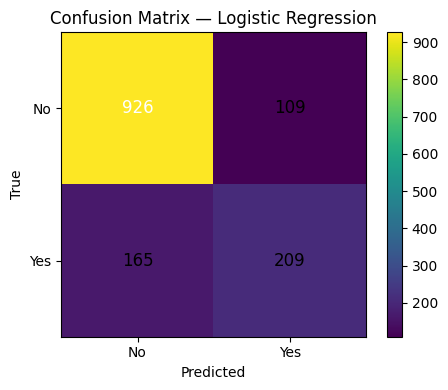

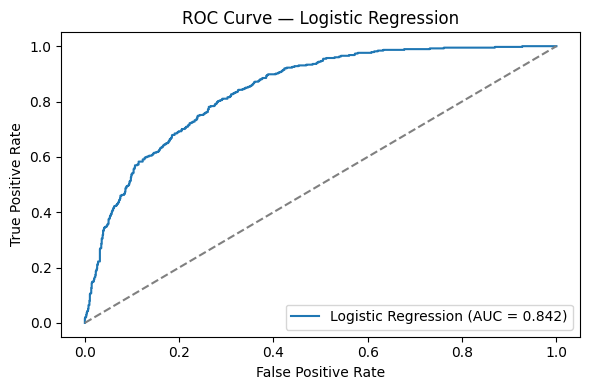


Random Forest — Test Metrics
Accuracy: 0.7842  Precision: 0.6151  Recall: 0.5000  F1: 0.5516  ROC_AUC: 0.8185

Classification Report:
              precision    recall  f1-score   support

           0     0.8308    0.8870    0.8579      1035
           1     0.6151    0.5000    0.5516       374

    accuracy                         0.7842      1409
   macro avg     0.7230    0.6935    0.7048      1409
weighted avg     0.7735    0.7842    0.7766      1409



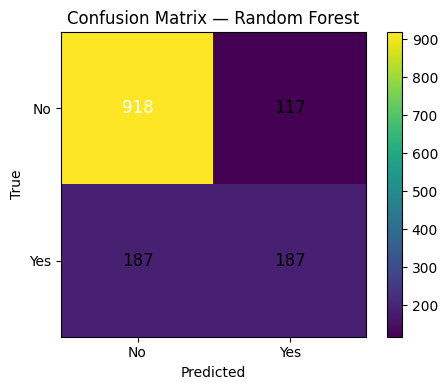

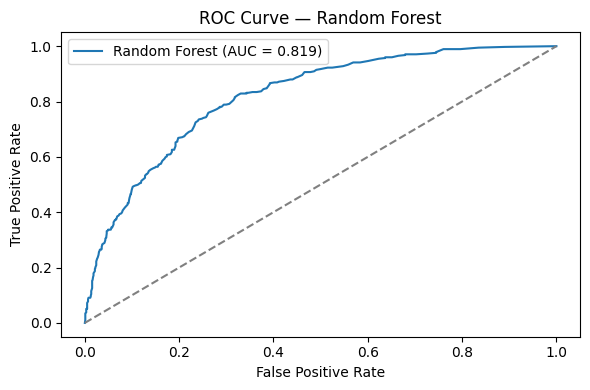


XGB/GradientBoosting — Test Metrics
Accuracy: 0.8070  Precision: 0.6747  Recall: 0.5267  F1: 0.5916  ROC_AUC: 0.8434

Classification Report:
              precision    recall  f1-score   support

           0     0.8415    0.9082    0.8736      1035
           1     0.6747    0.5267    0.5916       374

    accuracy                         0.8070      1409
   macro avg     0.7581    0.7175    0.7326      1409
weighted avg     0.7972    0.8070    0.7987      1409



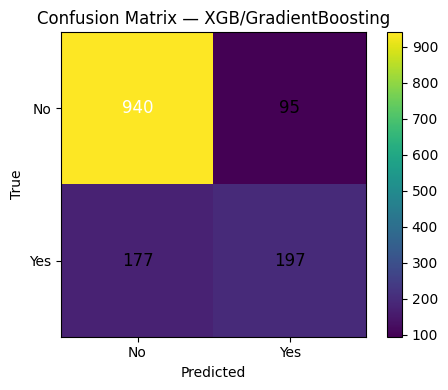

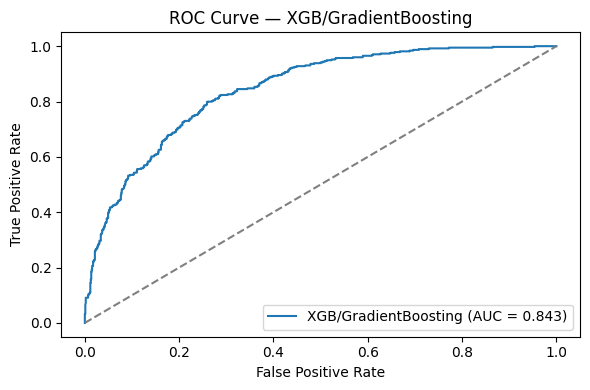


Model comparison (summary):
LogisticRegression: F1 = 0.6040, ROC_AUC = 0.8419
RandomForest: F1 = 0.5516, ROC_AUC = 0.8185
XGB_or_GB: F1 = 0.5916, ROC_AUC = 0.8434


In [30]:
scores = {}
scores['LogisticRegression'] = evaluate(log_pipe, X_train, y_train, X_test, y_test, "Logistic Regression")
scores['RandomForest'] = evaluate(rf_pipe, X_train, y_train, X_test, y_test, "Random Forest")
scores['XGB_or_GB'] = evaluate(xgb_pipe, X_train, y_train, X_test, y_test, "XGB/GradientBoosting")

print("\nModel comparison (summary):")
for k, v in scores.items():
    print(f"{k}: F1 = {v['f1']:.4f}, ROC_AUC = {v['roc_auc']:.4f}")

preprocessor_fit = preprocessor.fit(X_train)

num_feats = final_numerical

ohe = preprocessor_fit.named_transformers_['cat'].named_steps['onehot']
if hasattr(ohe, 'get_feature_names_out'):
    cat_feats = list(ohe.get_feature_names_out(final_categorical))
else:
    cat_feats = []
    for i, cat in enumerate(final_categorical):
        cats = preprocessor_fit.named_transformers_['cat'].named_steps['onehot'].categories_[i]
        cat_feats += [f"{cat}_{c}" for c in cats]

In [31]:
feature_names = num_feats + cat_feats
print("\nTotal features after preprocessing:", len(feature_names))



Total features after preprocessing: 41


,feature,importance
0,TotalCharges,0.166937
1,MonthlyCharges,0.144333
2,tenure,0.139892
3,Contract_Month-to-month,0.059264
4,TechSupport_No,0.033993
5,PaymentMethod_Electronic check,0.029376
6,OnlineSecurity_No,0.029281
7,PaperlessBilling,0.025168
8,InternetService_Fiber optic,0.024211
9,Partner,0.022808


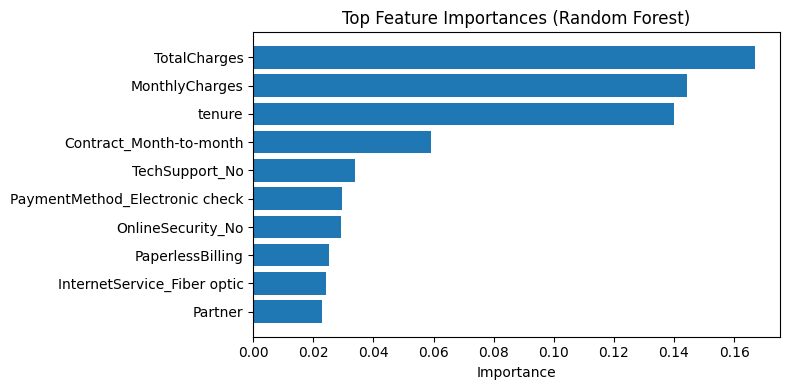

In [32]:
rf_clf = rf_pipe.named_steps['clf']
if hasattr(rf_clf, 'feature_importances_'):
    importances = rf_clf.feature_importances_
    feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    display(feat_imp_df.head(20))
    # Plot top 10
    top_n = 10
    top = feat_imp_df.head(top_n).sort_values(by='importance')
    plt.figure(figsize=(8,4))
    plt.barh(top['feature'], top['importance'])
    plt.title("Top Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("RandomForest does not expose feature_importances_.")

In [33]:
best_name = max(scores.items(), key=lambda x: x[1]['f1'])[0]
print("\nBest model by F1:", best_name)

if best_name == 'LogisticRegression':
    best_pipeline = log_pipe
elif best_name == 'RandomForest':
    best_pipeline = rf_pipe
else:
    best_pipeline = xgb_pipe

SAVE_PATH = "./churn_model_pipeline.pkl"
joblib.dump(best_pipeline, SAVE_PATH)
print(f"Saved best model pipeline to: {SAVE_PATH}")


Best model by F1: LogisticRegression
Saved best model pipeline to: ./churn_model_pipeline.pkl


In [34]:
summary = {
    "model": best_name,
    "metrics": scores[best_name]
}
print("\nSummary:", summary)

# End of script
print("\nAll done. You now have: EDA, preprocessing, trained models, evaluation plots, feature importances, and saved pipeline.")


Summary: {'model': 'LogisticRegression', 'metrics': {'accuracy': 0.8055358410220014, 'precision': 0.6572327044025157, 'recall': 0.5588235294117647, 'f1': 0.6040462427745664, 'roc_auc': 0.8418533157663594}}

All done. You now have: EDA, preprocessing, trained models, evaluation plots, feature importances, and saved pipeline.


In [35]:
!pip freeze > requirements.txt

In [36]:
pip list --format=freeze

altair==5.5.0
anyio==4.11.0
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
arrow==1.3.0
asttokens==3.0.0
async-lru==2.0.5
attrs==25.4.0
babel==2.17.0
beautifulsoup4==4.14.2
bleach==6.2.0
blinker==1.9.0
cachetools==6.2.1
certifi==2025.10.5
cffi==2.0.0
charset-normalizer==3.4.4
click==8.3.0
colorama==0.4.6
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.7.1
executing==2.2.1
fastjsonschema==2.21.2
fonttools==4.60.1
fqdn==1.5.1
gitdb==4.0.12
GitPython==3.1.45
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.11
ipykernel==7.0.1
ipython==9.6.0
ipython_pygments_lexers==1.1.1
ipywidgets==8.1.7
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.5.2
json5==0.12.1
jsonpointer==3.0.0
jsonschema==4.25.1
jsonschema-specifications==2025.9.1
jupyter==1.1.1
jupyter_client==8.6.3
jupyter-console==6.6.3
jupyter_core==5.8.1
jupyter-events==0.12.0
jupyter-lsp==2.3.0
jupyter_server==2.17.0
jupyter_server_terminals==0.5.3
jupyterlab==4.4.9
jupyterlab_pygme


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: C:\Users\PMLS\Desktop\Career\ML-Projects\Customer_Churn_Prediction\env\Scripts\python.exe -m pip install --upgrade pip


In [37]:
import numpy as np
print(np.__version__)


2.1.3


In [38]:
import joblib

joblib.dump(categorical_features, "categorical_features.pkl")


['categorical_features.pkl']

In [39]:
joblib.dump(numerical_features, "numerical_features.pkl")

['numerical_features.pkl']